# Preprocess data

## 1. Extract data

In [1]:
import pandas as pd

In [2]:
# Load routes
routes = pd.read_csv("./data/routes.dat",
                      names = ["airline",
                              "airline_id",
                              "source_airport",
                              "source_airport_id",
                              "destination_airport",
                              "destination_airport_id",
                              "codeshare",
                              "stops",
                              "equipment"])

In [3]:
routes.head()

,airline,airline_id,source_airport,source_airport_id,destination_airport,destination_airport_id,codeshare,stops,equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


In [4]:
# Load airports 
airports = pd.read_csv("data/airports.dat",
                       names = ["airport_id", "Name", "City", "Country", "IATA",
                                "ICAO", "Latitude", "Longitude",
                                "Altitude", "Timezone", "DST",
                                "TzDatabase", "Type", "Source"])

In [5]:
airports.head()

,airport_id,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,TzDatabase,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports


In [18]:
# clean the data
airports_routes = list(set(routes['source_airport']) | set(routes['destination_airport']))
airports_airports = list(airports['IATA'])

airports_cleaned = list(set(airports_routes) & set(airports_airports))

routes_cleaned = routes[routes['source_airport'].isin(airports_cleaned) & routes['destination_airport'].isin(airports_cleaned)]

airports_cleaned = airports[airports['IATA'].isin(airports_cleaned)]

In [23]:
print(f'The original number of routes is {len(routes)}, and the reduced number of routes is {len(routes_cleaned)}')

The original number of routes is 67663, and the reduced number of routes is 66934


In [26]:
print(f'The original number of airports is {len(airports)}, and the reduced number of airports is {len(airports_cleaned)}')

The original number of airports is 7698, and the reduced number of airports is 3262


In [27]:
# save
routes_cleaned.to_csv('data/routes_cleaned.csv')
airports_cleaned.to_csv('data/airports_cleaned.csv')

## 2. Create graph

### 2.1 Create nodes

In [6]:
import numpy as np

In [7]:
# Get source and destination airports from routes
src_airports = routes[["source_airport_id", "source_airport"]]
src_airports.columns = ["airport_id", "airport"]
dst_airports = routes[["destination_airport_id", "destination_airport"]]
dst_airports.columns = ["airport_id", "airport"]

# Create nodes from airports
nodes = pd.concat([src_airports, dst_airports], axis = 0).drop_duplicates()
nodes.replace(to_replace = "\\N", value = np.NaN, inplace = True)
nodes.dropna(axis = 0, inplace = True)
nodes["airport_id"] = nodes["airport_id"].apply(int)

In [8]:
airports.columns

Index(['airport_id', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude',
       'Longitude', 'Altitude', 'Timezone', 'DST', 'TzDatabase', 'Type',
       'Source'],
      dtype='object')

In [9]:
# Add latitudes, longitudes and continents to nodes
nodes = nodes.merge(right = airports[["airport_id", "Latitude", "Longitude", "TzDatabase"]],
                    left_on = "airport_id",
                    right_on = "airport_id")

nodes.set_index("airport_id", inplace = True)
nodes["TzDatabase"] = nodes["TzDatabase"].str.split('/').str[0]

In [10]:
# Set proper names to columns and index of nodes
nodes.columns = ["Airport", "Latitude", "Longitude", "Continent"]
nodes.index.name = "Airport_id"

In [11]:
nodes.head()

,Airport,Latitude,Longitude,Continent
Airport_id,,,,
2965,AER,43.449902,39.956600,Europe
2966,ASF,46.283298,48.006302,Europe
2968,CEK,55.305801,61.503300,Asia
4029,DME,55.408798,37.906300,Europe
6156,EGO,50.643799,36.590099,Europe


### 2.2 Create edges

In [12]:
# Create edges from routes between airports
edges = routes[["source_airport_id", "destination_airport_id"]]
edges = edges.replace(to_replace = "\\N", value = np.NaN)
edges.dropna(axis = 0, inplace = True)

# Convert edges id to int
edges["source_airport_id"] = edges["source_airport_id"].apply(int)
edges["destination_airport_id"] = edges["destination_airport_id"].apply(int)

In [13]:
edges.head()

,source_airport_id,destination_airport_id
0,2965,2990
1,2966,2990
2,2966,2962
3,2968,2990
4,2968,4078


In [14]:
# Create mapping from airport id to node id
airport_id2idx = pd.DataFrame(nodes.index.unique())
airport_id2idx = airport_id2idx.reset_index()\
                                .set_index("Airport_id")
airport_id2idx.columns = ["nodes_idx"]

In [15]:
# Add node_ids to edges for adjacency matrix construction
edges = edges.merge(right = airport_id2idx,
                   left_on = "source_airport_id",
                   right_index = True,
                   sort = False)

edges = edges.merge(right = airport_id2idx,
                   left_on = "destination_airport_id",
                   right_index = True,
                   sort = False,
                   suffixes = ["_src", "_dst"])

edges.drop_duplicates(inplace = True)

In [16]:
edges.head()

,source_airport_id,destination_airport_id,nodes_idx_src,nodes_idx_dst
0,2965,2990,0,7
1,2966,2990,1,7
3,2968,2990,2,7
5,4029,2990,3,7
10,6156,2990,4,7


## 3. Create adjacency matrix

In [31]:
import networkx as nx
G_non_weighted = nx.from_pandas_edgelist(routes_cleaned, 'source_airport', 'destination_airport')

### 3.1 Create non-weighted adjacency matrix

In [33]:
from collections import Counter
degrees = [d for _, d in G_non_weighted.degree()]

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

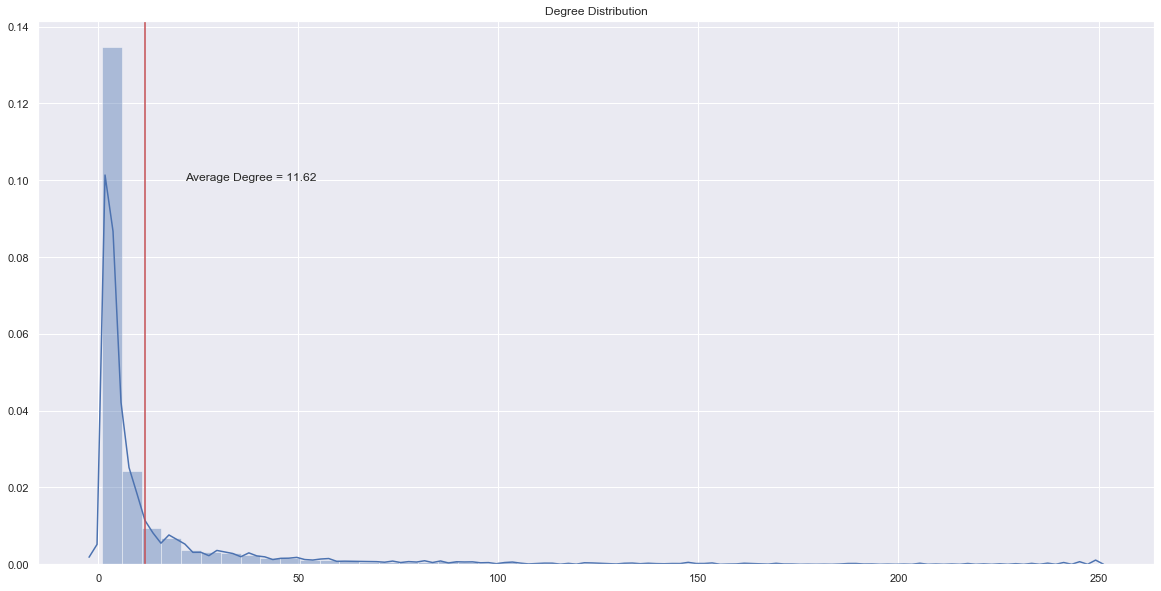

In [71]:
sns.set()
# calculate the mean
fig, ax = plt.subplots(figsize=(20, 10))
sns.distplot(degrees, color='b')
degree_mean = np.mean(degrees)
plt.title('Degree Distribution')
plt.axvline(degree_mean, 0, 1, color='r')
plt.text(degree_mean+10, 0.1, 'Average Degree = {0:.2f}'.format(degree_mean))
plt.show()